## IMPORTS

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.18.1 scipy==1.7.0 pandas==1.3.5 scikit-learn==0.22.1 statsmodels==0.11.0 pynndescent==0.5.5


## READ DATA

In [4]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

  0%|          | 0.00/7.86M [00:00<?, ?B/s]

  0%|          | 0.00/29.3M [00:00<?, ?B/s]

reading data\V1_Human_Lymph_Node\filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [32]:
adata

AnnData object with n_obs × n_vars = 3861 × 19685
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'rank_genes_groups'
    obsm: 'spatial'

## QC AND PREPROCESSING

C:\Users\alon2\anaconda3\envs\FPST\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

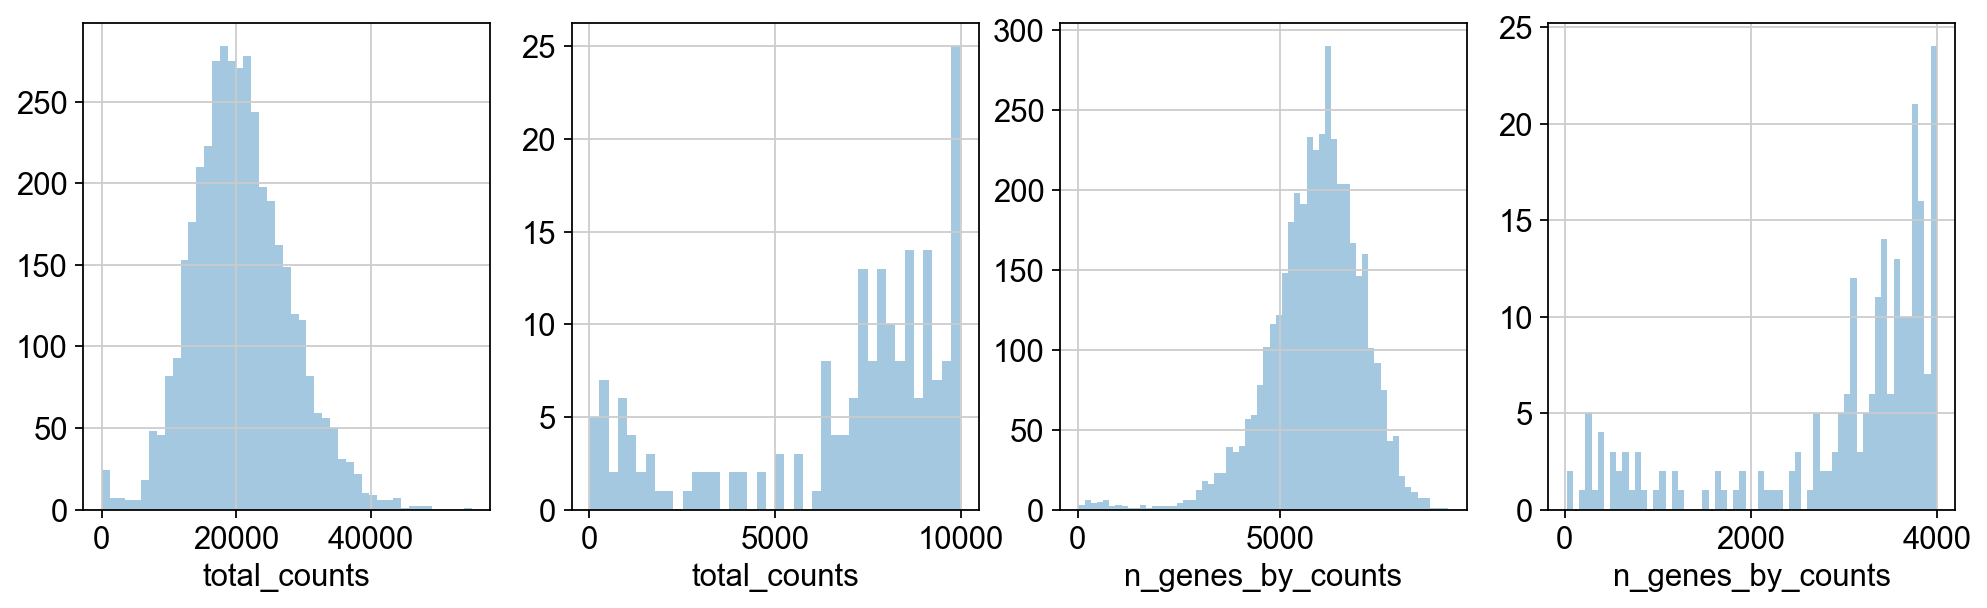

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])


## FILTER CELLS

In [7]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

filtered out 44 cells that have less than 5000 counts
filtered out 130 cells that have more than 35000 counts
#cells after MT filter: 3861
filtered out 16916 genes that are detected in less than 10 cells


Trying to set attribute `.var` of view, copying.


## NORMALIZE THE DATA AND DETECT HIGHLY VARIABLE GENES

In [8]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [39]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
running Leiden clustering
    finished: found 10 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


## COVARIATES

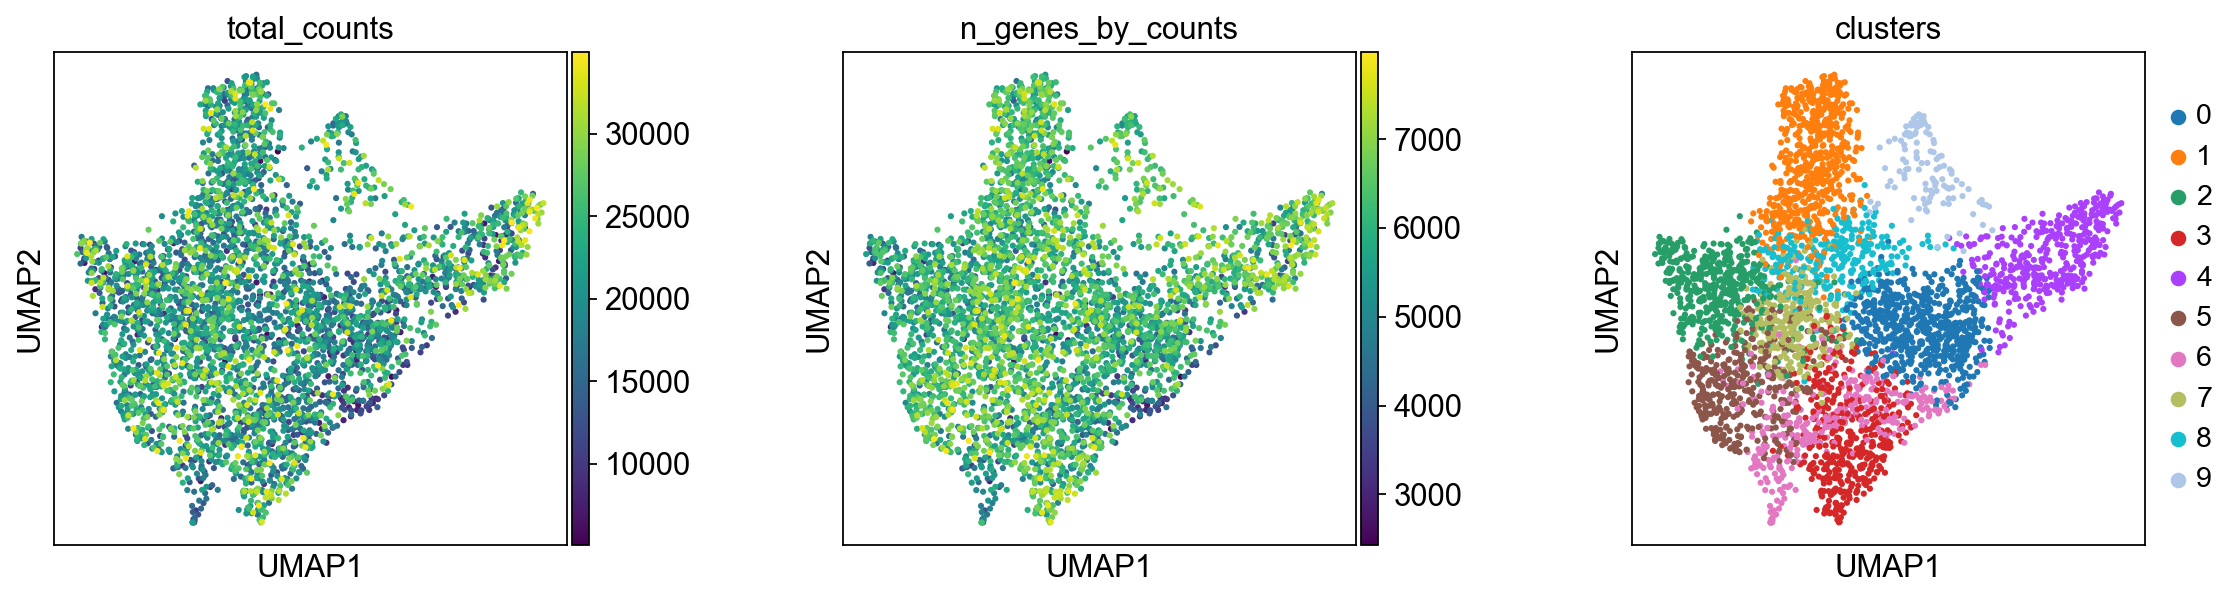

In [47]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

## VISUALIZE WITH SPATIAL COORDINATES

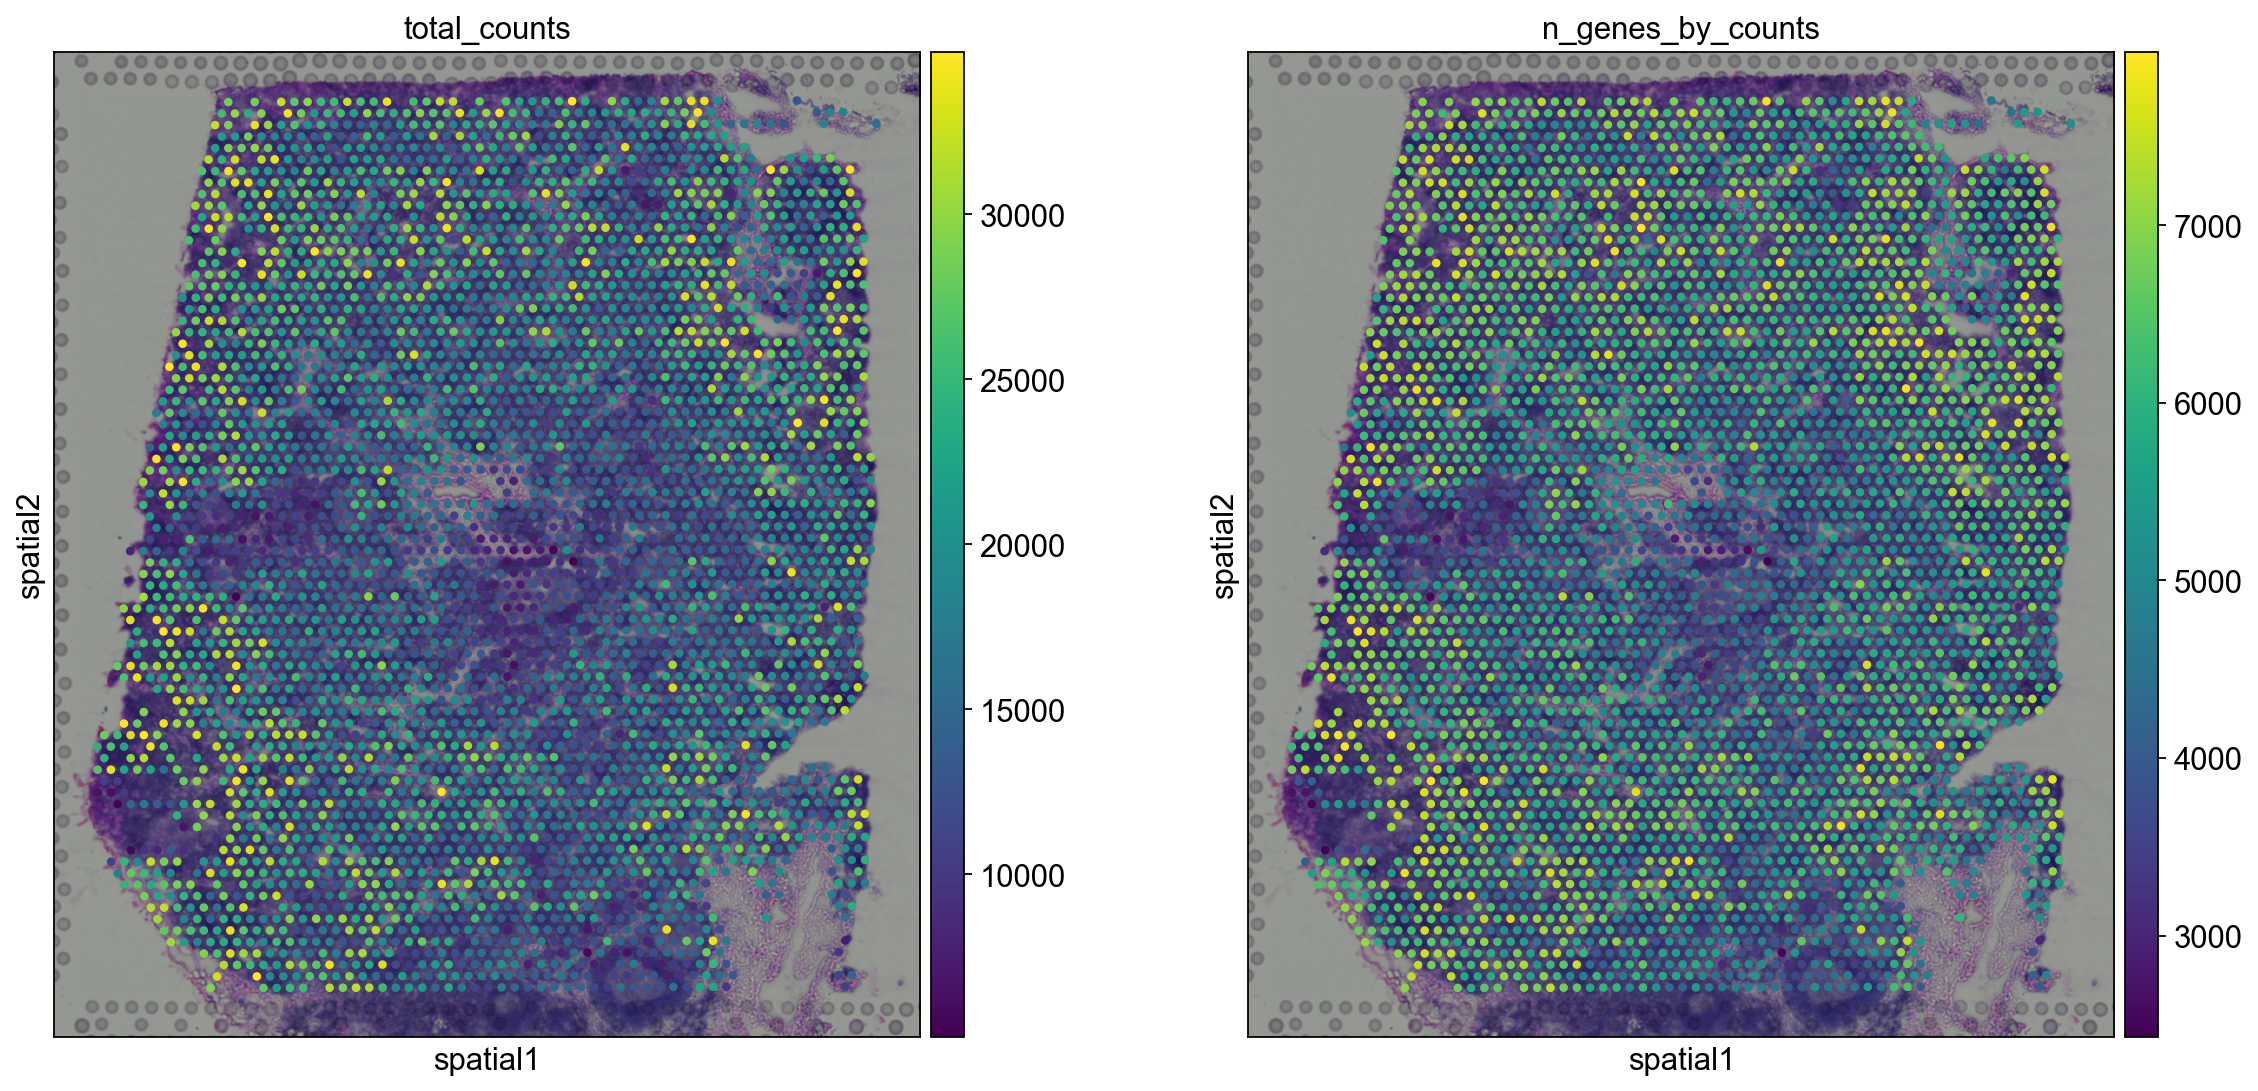

In [41]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

## PLAYING WITH 'size' VARIABLE

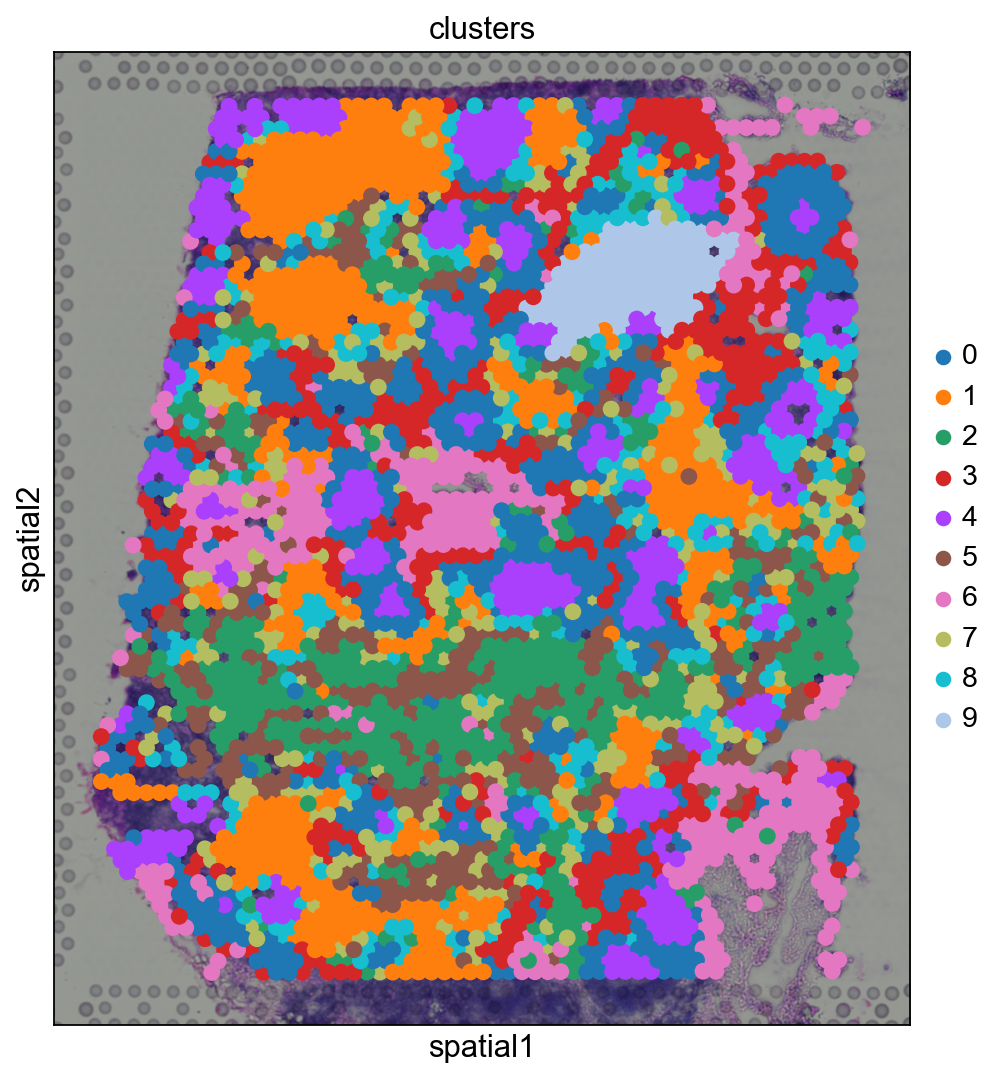

In [43]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=2)

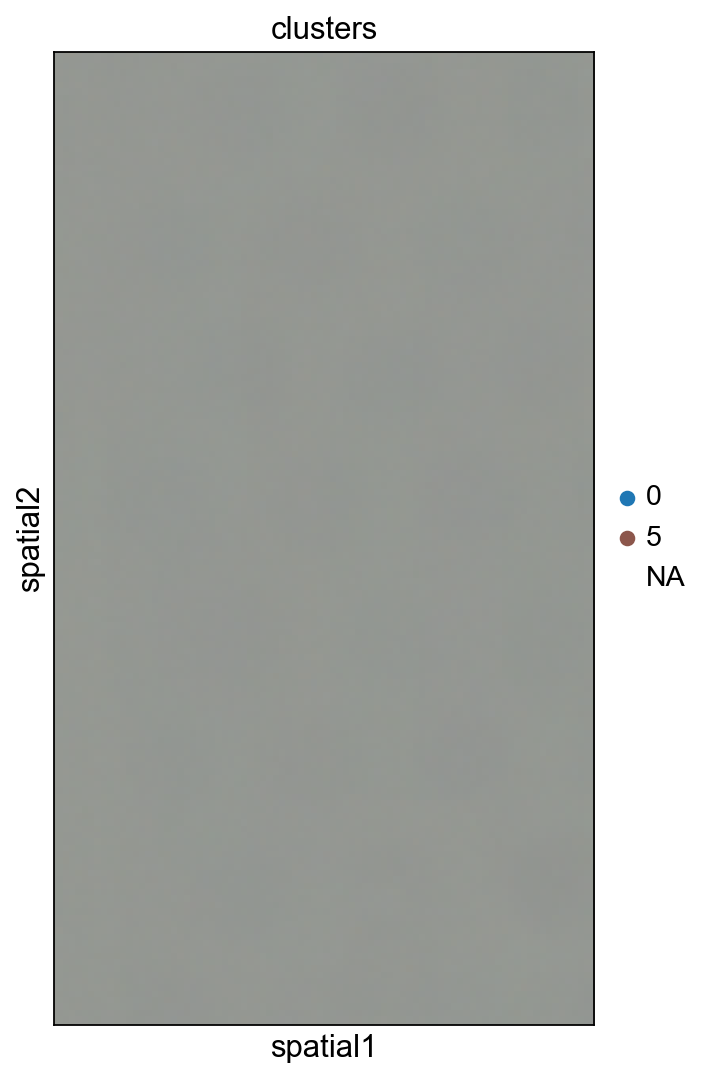

In [44]:
sc.pl.spatial(adata, img_key="hires", color="clusters", groups=["0", "5"], crop_coord=[1200, 1700, 1900, 1000], alpha=0.5, size=1.3)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`
categories: 0, 1, 2, etc.
var_group_labels: 5


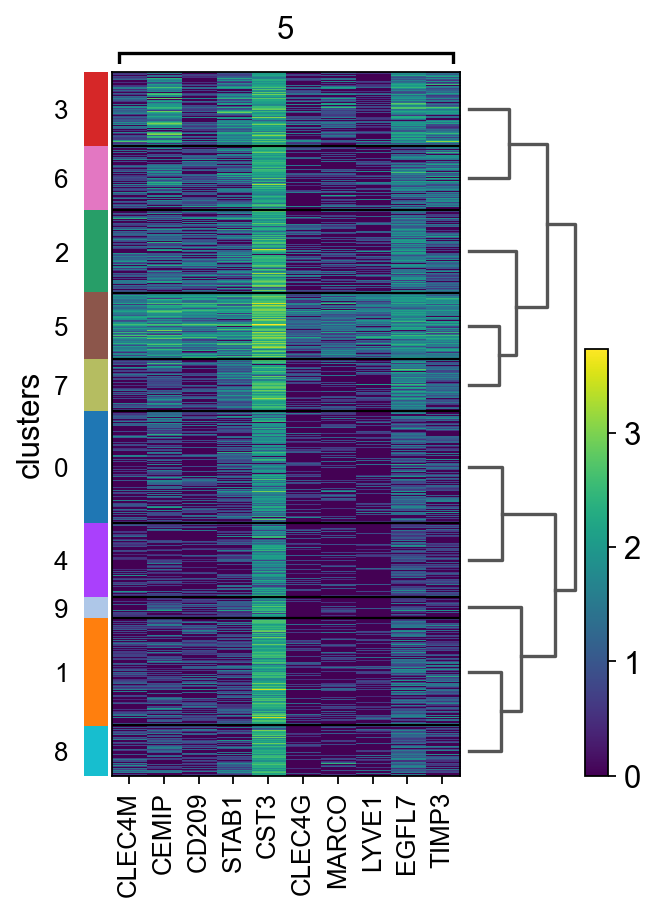

In [46]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="5", n_genes=10, groupby="clusters")

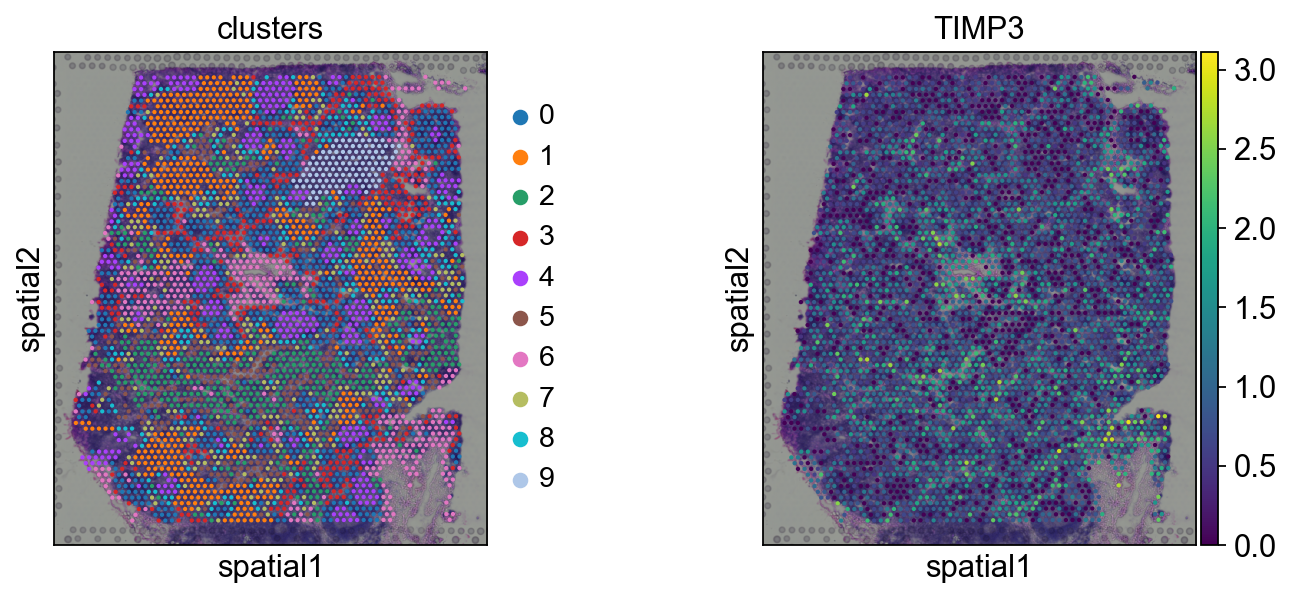

In [52]:
sc.pl.spatial(adata, img_key="hires", color=["clusters", "TIMP3"])

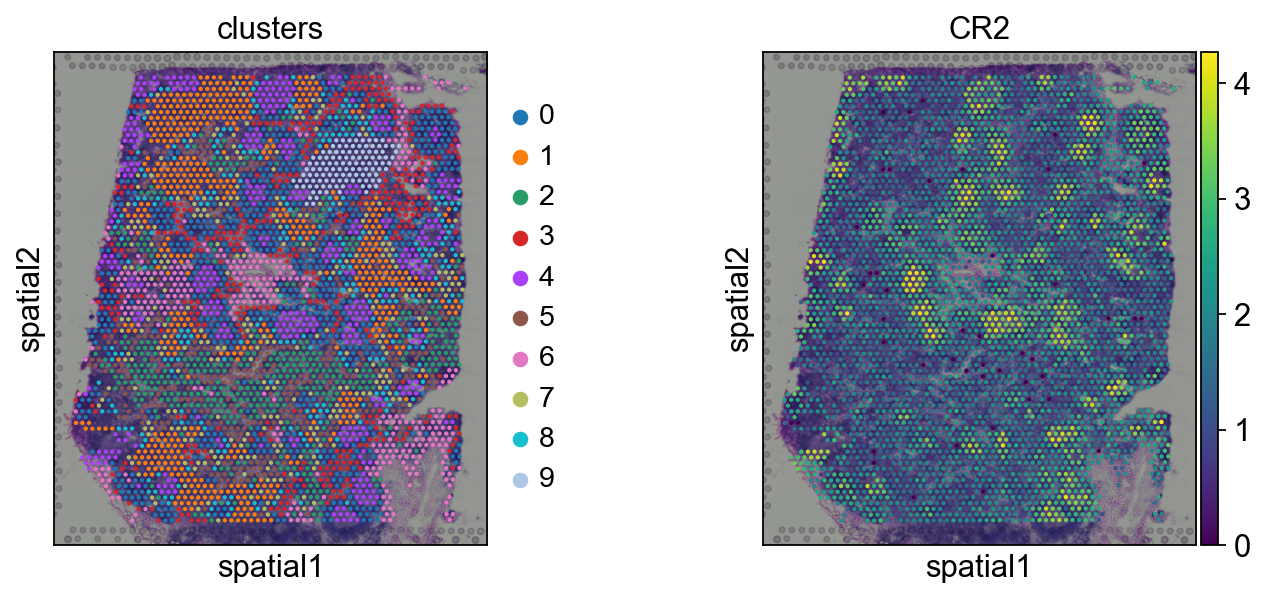

In [51]:
sc.pl.spatial(adata, img_key="hires", color=["clusters", "CR2"])

In [53]:
pip install spatialde

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.
  Created wheel for NaiveDE: filename=NaiveDE-1.2.0-py3-none-any.whl size=5713 sha256=7611c321fd6ce3bfb966e4f052fc561b00fe9f973a27148dceed7cabd737490c
  Stored in directory: c:\users\alon2\appdata\local\pip\cache\wheels\01\34\53\eff6dafc79c8f34e98fce9705fbcbc458461172e53adb65d16
Successfully built NaiveDE


In [54]:
import SpatialDE

In [55]:
%%time
counts = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs_names)
coord = pd.DataFrame(adata.obsm['spatial'], columns=['x_coord', 'y_coord'], index=adata.obs_names)
results = SpatialDE.run(coord, counts)

C:\Users\alon2\anaconda3\envs\FPST\lib\site-packages\SpatialDE\base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
C:\Users\alon2\anaconda3\envs\FPST\lib\site-packages\SpatialDE\base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

C:\Users\alon2\anaconda3\envs\FPST\lib\site-packages\SpatialDE\base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)


  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

Wall time: 38min 44s


In [56]:
results.index = results["g"]
adata.var = pd.concat([adata.var, results.loc[adata.var.index.values, :]], axis=1)

In [57]:
results.sort_values("qval").head(10)

FSV  M        g           l  max_delta       max_ll  max_mu_hat  \
g                                                                               
GNLY     0.076871  4     GNLY  474.158722  11.778479 -2593.983424    0.371093   
RPL12    0.325729  4    RPL12  248.797504   2.058987   658.243147    3.636466   
TNC      0.236235  4      TNC  248.797504   3.215826 -3510.193411    1.214372   
HERPUD1  0.104167  4  HERPUD1  474.158722   8.434975 -2774.819343    1.618653   
MT2A     0.123076  4     MT2A  474.158722   6.988372 -3204.546834    1.293135   
RPL35    0.217806  4    RPL35  474.158722   3.522356   810.352536    3.639962   
PSAP     0.230319  4     PSAP  130.547421   3.337378 -1211.343253    2.836226   
FUS      0.081397  4      FUS  474.158722  11.068937 -1529.996810    2.282976   
CCL21    0.803991  4    CCL21  248.797504   0.242494  -727.100652    4.268608   
CCL19    0.524047  4    CCL19  248.797504   0.903380 -2625.176553    2.222744   

         max_s2_t_hat model     n        s2_FSV  s2_logdelta      time  \
g                                                                        
GNLY         0.019943    SE  3861  8.269986e-06     0.001380  0.018996   
RPL12        0.604301    SE  3861  3.693007e-06     0.000085  0.011003   
TNC          0.158132    SE  3861  4.600958e-06     0.000146  0.005000   
HERPUD1      0.061453    SE  3861  1.082895e-05     0.001092  0.005999   
MT2A         0.063609    SE  3861  1.094055e-05     0.000849  0.007003   
RPL35        0.196553    SE  3861  1.466402e-05     0.000514  0.000000   
PSAP         0.885015    SE  3861  5.470798e-06     0.000179  0.010000   
FUS          0.075612    SE  3861  1.040737e-05     0.001576  0.015000   
CCL21        1.114261    SE  3861  7.781889e-07     0.000031  0.006996   
CCL19        0.420161    SE  3861  2.489210e-06     0.000047  0.003999   

                 BIC  max_ll_null          LLR  pval  qval  
g                                                           
GNLY     5221.001573 -2676.898335    82.914912   0.0   0.0  
RPL12   -1283.451567   185.681828   472.561318   0.0   0.0  
TNC      7053.421547 -3746.417006   236.223596   0.0   0.0  
HERPUD1  5582.673412 -2893.342714   118.523370   0.0   0.0  
MT2A     6442.128394 -3357.983821   153.436987   0.0   0.0  
RPL35   -1587.670346   486.288938   324.063598   0.0   0.0  
PSAP     2455.721233 -1304.143049    92.799795   0.0   0.0  
FUS      3093.028346 -1608.994159    78.997349   0.0   0.0  
CCL21    1487.236031 -2869.867834  2142.767182   0.0   0.0  
CCL19    5283.387832 -3534.248603   909.072050   0.0   0.0

C:\Users\alon2\anaconda3\envs\FPST\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'model' as categorical


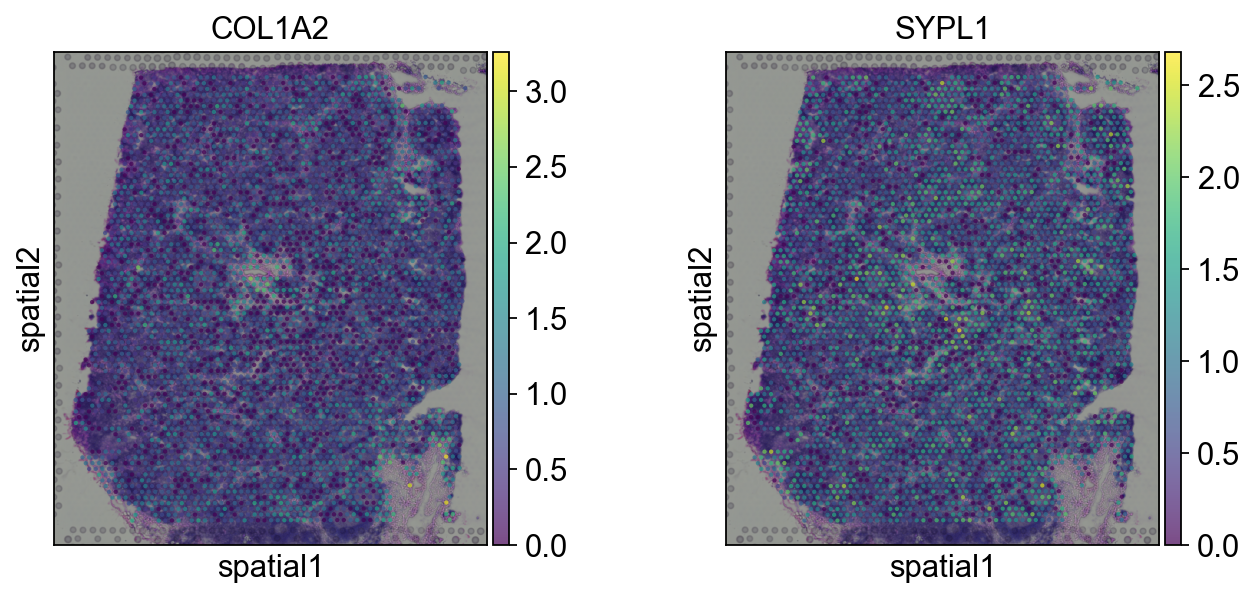

In [58]:
sc.pl.spatial(adata, img_key="hires", color=["COL1A2", "SYPL1"], alpha=0.7)